# Introduzione
L'obiettivo di questo notebook è quello di addestrare e valutare quattro modelli per stimare il prezzo di vendita di automobili usate, a partire da un dataset (car_prices.csv) contenente le seguenti feature:

*   **manufacturer**: produttore
*   **model**: modello
*   **year**: anno di produzione
*   **transmission**: trasmissione
*   **mileage**: chilometraggio (in miglia)
*   **fuelType**: carburante
*   **mpg**: consumo (miglia per gallone)
*   **engineSize**: cilindrata del motore
*   **price**: prezzo

I modelli che andremo a considerare sono:

*   **Linear Regression**
*   **Random Forest Regressor**
*   **Neural Network**
*   **?????**

Le metriche utilizzate per confrontare le performance saranno:

* **Mean Absolute Error (MAE)**
* **R² Score**


### Imports






In [3]:
!pip install keras-tuner
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from keras.optimizers import Adam
from keras_tuner import HyperParameters, RandomSearch
from xgboost import XGBRegressor



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.7 MB/s eta 0:00:00


# Fase 1: Import Dataset e manipolazione




In [6]:
# loading the data from csv file
car_dataset = pd.read_csv('car_prices.csv')

# split price in y
X = car_dataset.drop('price', axis=1)
y = car_dataset['price']

Verifichiamo ora come appare il dataset:

In [5]:
car_dataset.head()

,manufacturer,model,year,transmission,mileage,fuelType,mpg,engineSize,price
0,Audi,A1,2017,Manual,15735,Petrol,55.4,1.4,12500
1,Audi,A6,2016,Automatic,36203,Diesel,64.2,2.0,16500
2,Audi,A1,2016,Manual,29946,Petrol,55.4,1.4,11000
3,Audi,A4,2017,Automatic,25952,Diesel,67.3,2.0,16800
4,Audi,A3,2019,Manual,1998,Petrol,49.6,1.0,17300


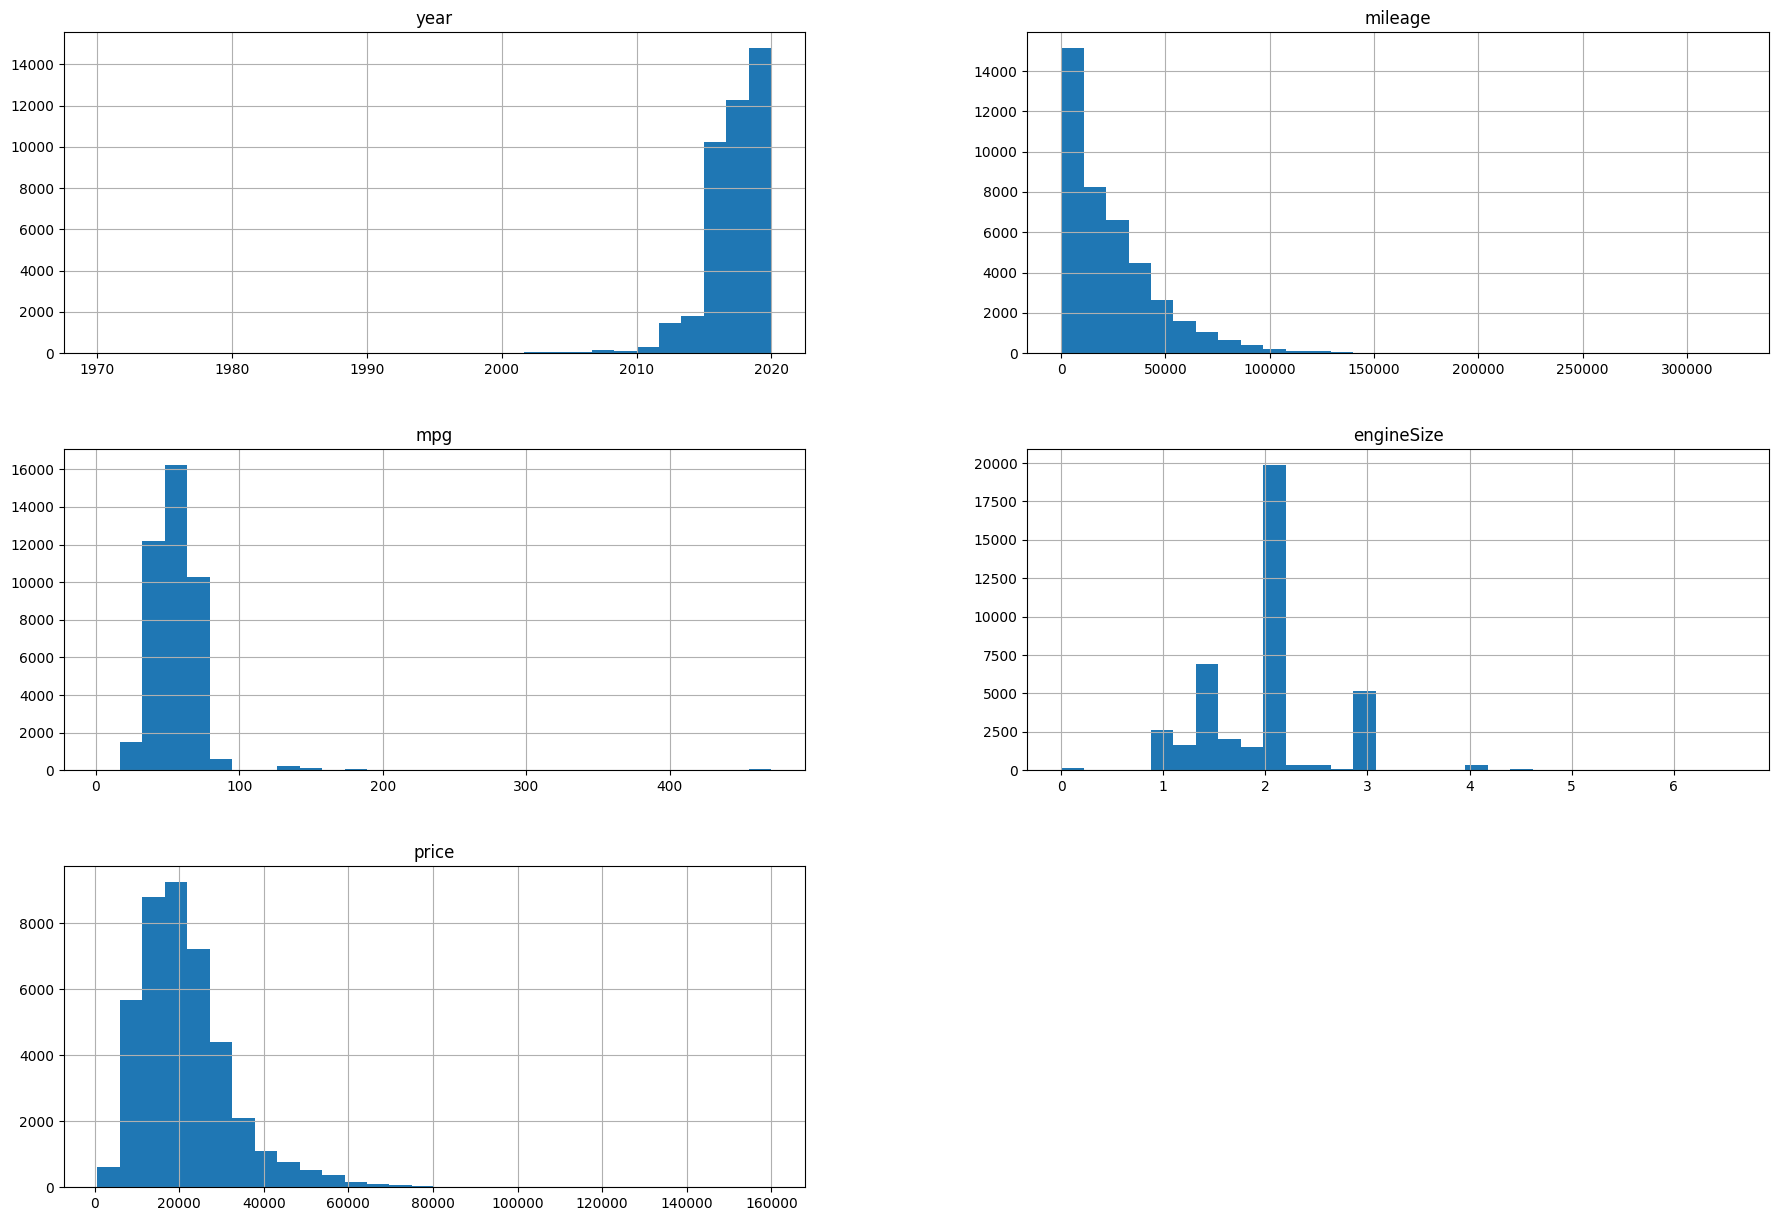

In [9]:
car_dataset.hist(bins=30, figsize=(22,15))
plt.show()

E' opportuno verificare se nel dataset ci sono valori nulli:


In [10]:
print(car_dataset.isnull().sum())

manufacturer    0
model           0
year            0
transmission    0
mileage         0
fuelType        0
mpg             0
engineSize      0
price           0
dtype: int64


Non essendoci valori nulli, è possibile proseguire andando ad analizzare il tipo della feature. In particolare è necessario gestire le feature categoriche, in quanto i modelli che andremo ad usare possono utilizzare solamente feature numeriche.
Di seguito vengono mostrati i possibili valori per ogni feature categorica:

In [8]:
cat_c = X.select_dtypes(include=['object']).columns

for column in cat_c:
    print(f"\n{column}")
    print(car_dataset[column].unique())
print("\n")


manufacturer
['Audi' 'BMW' 'Toyota' 'Mercedes']

model
[' A1' ' A6' ' A4' ' A3' ' Q3' ' Q5' ' A5' ' S4' ' Q2' ' A7' ' TT' ' Q7'
 ' RS6' ' RS3' ' A8' ' Q8' ' RS4' ' RS5' ' R8' ' SQ5' ' S8' ' SQ7' ' S3'
 ' S5' ' A2' ' RS7' ' 5 Series' ' 6 Series' ' 1 Series' ' 7 Series'
 ' 2 Series' ' 4 Series' ' X3' ' 3 Series' ' X5' ' X4' ' i3' ' X1' ' M4'
 ' X2' ' X6' ' 8 Series' ' Z4' ' X7' ' M5' ' i8' ' M2' ' M3' ' M6' ' Z3'
 ' GT86' ' Corolla' ' RAV4' ' Yaris' ' Auris' ' Aygo' ' C-HR' ' Prius'
 ' Avensis' ' Verso' ' Hilux' ' PROACE VERSO' ' Land Cruiser' ' Supra'
 ' Camry' ' Verso-S' ' IQ' ' Urban Cruiser' ' SLK' ' S Class' ' SL CLASS'
 ' G Class' ' GLE Class' ' GLA Class' ' A Class' ' B Class' ' GLC Class'
 ' C Class' ' E Class' ' GL Class' ' CLS Class' ' CLC Class' ' CLA Class'
 ' V Class' ' M Class' ' CL Class' ' GLS Class' ' GLB Class' ' X-CLASS'
 '180' ' CLK' ' R Class' '230' '220' '200']

transmission
['Manual' 'Automatic' 'Semi-Auto' 'Other']

fuelType
['Petrol' 'Diesel' 'Hybrid' 'Other' 'E

Ad ogni feature categorica, applichiamo ora sklearn's OneHotEncoder, che andrà a convertire le colonne rappresentanti feature categoriche in colonne con un formato binario (one-hot encoding)

In [9]:
feat_cat = [
    'manufacturer',
    'model',
    'transmission',
    'fuelType'
]

X_cat = X[feat_cat]

encoder = OneHotEncoder(sparse_output=False)
X_encoded = pd.DataFrame(encoder.fit_transform(X_cat), columns=encoder.get_feature_names_out(feat_cat))
X = pd.concat([X.drop(feat_cat, axis=1), X_encoded], axis=1)

In [10]:
#visualizziamo come diventa il dataset
X.head()


,year,mileage,mpg,engineSize,manufacturer_Audi,manufacturer_BMW,manufacturer_Mercedes,manufacturer_Toyota,model_ 1 Series,model_ 2 Series,...,model_230,transmission_Automatic,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Diesel,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
0,2017,15735,55.4,1.4,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2016,36203,64.2,2.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2016,29946,55.4,1.4,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2017,25952,67.3,2.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2019,1998,49.6,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Adesso andiamo ad effettuare lo split del dataset in training set e testing set usando uno split pari a 75/25.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fase 2: Addestramento e valutazione modelli

## Linear Regression

Consideriamo per primo un semplice modello di regressione lineare

In [24]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

predicted_prices_lr = lr.predict(X_test_scaled)

lr_mae = mean_absolute_error(y_test , predicted_prices_lr)
lr_r2 = r2_score(y_test, predicted_prices_lr)

print('Linear regression test MAE = ', lr_mae)
print('Linear regression test R^2 = ', lr_r2)

Linear regression test MAE =  3034.377347410895
Linear regression test R^2 =  0.8271891644493958


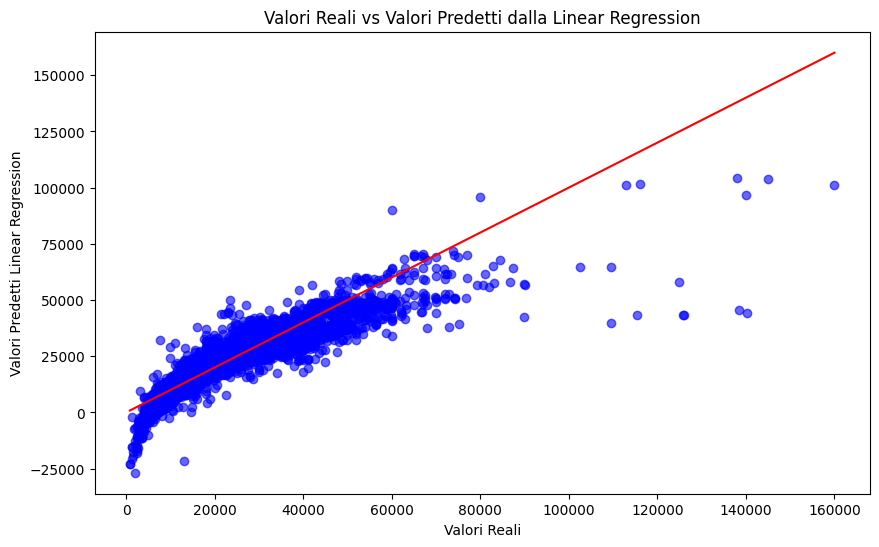

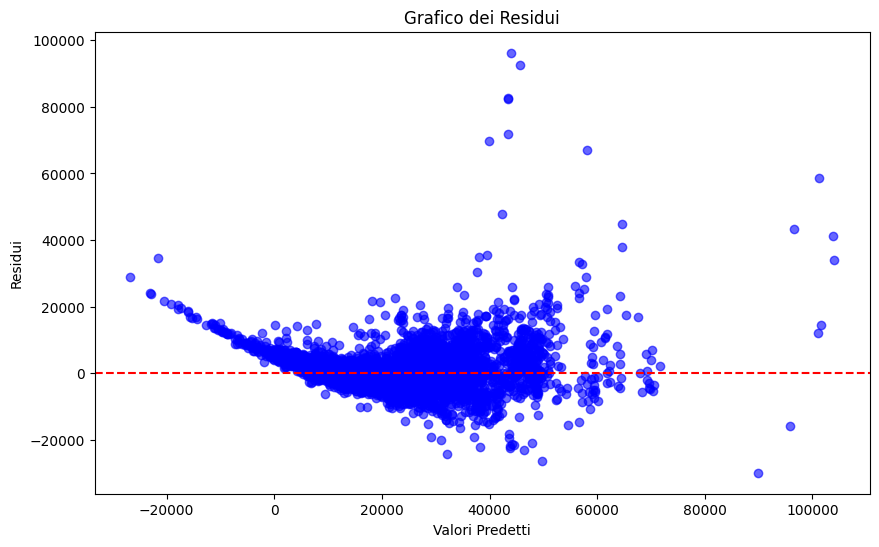

In [25]:
#osserviamo ora i plot del grafico che mostra la relazione tra i valori reali e quelli predetti
#(maggior elementi vicino la linea rossa == miglior predizione)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, predicted_prices_lr, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel('Valori Reali')
plt.ylabel('Valori Predetti Linear Regression')
plt.title('Valori Reali vs Valori Predetti dalla Linear Regression')
plt.show()

#ed il grafico dei residui
residuals = y_test - predicted_prices_lr

plt.figure(figsize=(10, 6))
plt.scatter(predicted_prices_lr, residuals, color='blue', alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Valori Predetti')
plt.ylabel('Residui')
plt.title('Grafico dei Residui')
plt.show()

## Random Forest Regressor

Addestriamo ora e valutiamo il modello Random Forest Regressor, basato su alberi decisionali.

In [14]:
rf_model = RandomForestRegressor()

param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'min_samples_split': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'min_samples_leaf': [1, 2, 9, 10],
}

random_search = RandomizedSearchCV(
    rf_model,
    param_distributions=param_dist,
    n_iter=10,
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train_scaled, y_train)

print("Best hyperparameters:", random_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best hyperparameters: {'n_estimators': 200, 'min_samples_split': 12, 'min_samples_leaf': 1}


Random Forest Regressor test MAE =  1433.3740011621253
Random Forest Regressor test R^2 =  0.9622457560002101


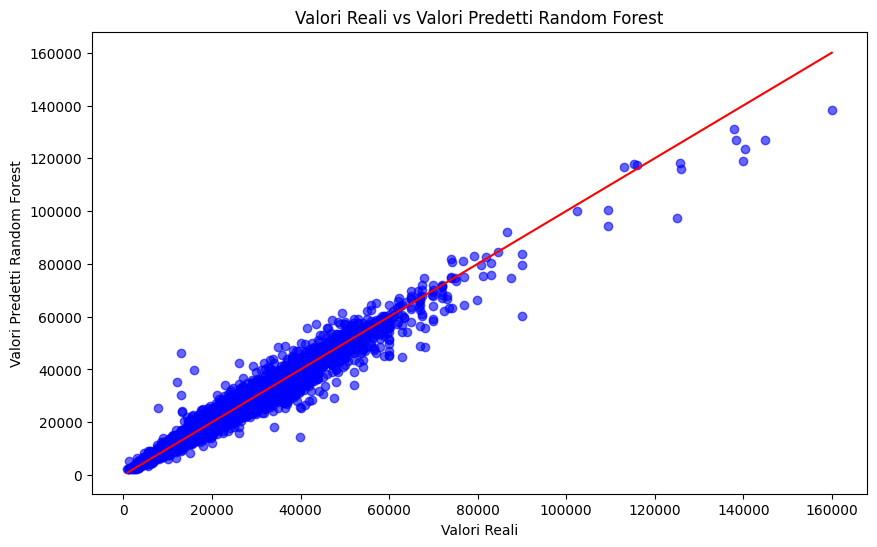

In [22]:
# settiamo i valori in base agli hyperparametri migliori
model_ok = RandomForestRegressor(n_estimators=100, min_samples_split=5, min_samples_leaf=1)

model_ok.fit(X_train_scaled, y_train)

predicted_prices_rf = model_ok.predict(X_test_scaled)

rf_mae = mean_absolute_error(y_test , predicted_prices_rf)
rf_r2 = r2_score(y_test, predicted_prices_rf)

print('Random Forest Regressor test MAE = ', rf_mae)
print('Random Forest Regressor test R^2 = ', rf_r2)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, predicted_prices_rf, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel('Valori Reali')
plt.ylabel('Valori Predetti Random Forest')
plt.title('Valori Reali vs Valori Predetti Random Forest')
plt.show()

## Neural Network

Andiamo ad utilizzare ora una rete neurale del tipo "multilayer percepton", come descritto nella documentazione. Definiamo inizialmente una funzione per la creazione del modello e dei vari livelli, tra cui input ed output

In [14]:
def create_NN_model(hp):
  model = Sequential()
  #input
  model.add(keras.Input(shape=(X_train.shape[1],)))

  #number of dense layer (tra 1 e 5) with 10-100 neuroni
  for i in range(hp.Int("num_layers", 1, 5)):
    model.add(
        Dense(
        units=hp.Int(f"units_{i}", min_value=10, max_value=100, step=10),
                activation="relu",
                kernel_initializer=hp.Choice('initializer', values=['glorot_normal', 'random_normal', 'glorot_uniform', 'he_normal'])
          )
    )

  #output
  model.add(
      Dense(units=1,
            kernel_initializer=hp.Choice('initializer', values=['glorot_normal', 'random_normal', 'glorot_uniform', 'he_normal']),
            activation='linear')
      )

  #tunable learning rate
  learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3]) #0.001 ---- 0.01

  # Compile the model
  model.compile(
      optimizer=Adam(learning_rate=learning_rate),
      loss='mean_absolute_error',
      metrics=['mean_absolute_error']
  )

  return model

In [1]:
from google.colab import drive

drive.mount('/content/drive/')


Mounted at /content/drive/


In [15]:
tuner = RandomSearch(
    create_NN_model,
    objective='val_mean_absolute_error',
    max_trials=5,
    directory='/content/drive/My Drive/tuning',
    project_name='Project_ML'
)


tuner.search(
    X_train_scaled, y_train,
    epochs=350,
    validation_split=0.2,
    callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=10)]
)

# summary
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model.summary()
print("")
tuner.results_summary()

Reloading Tuner from /content/drive/My Drive/tuning/Project_ML/tuner0.json


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 50)                  │           5,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 90)                  │           4,590 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 20)                  │           1,820 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 60)                  │           1,260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              61 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,381 (52.27 KB)

 Trainable params: 13,381 (52.27 KB)

 Non-trainable params: 0 (0.00 B)


Results summary
Results in /content/drive/My Drive/tuning/Project_ML
Showing 10 best trials
Objective(name="val_mean_absolute_error", direction="min")

Trial 4 summary
Hyperparameters:
num_layers: 4
units_0: 50
initializer: random_normal
learning_rate: 0.01
units_1: 90
units_2: 20
units_3: 60
units_4: 30
Score: 1517.092529296875

Trial 3 summary
Hyperparameters:
num_layers: 5
units_0: 100
initializer: glorot_uniform
learning_rate: 0.01
units_1: 80
units_2: 70
units_3: 50
units_4: 10
Score: 1520.11865234375

Trial 2 summary
Hyperparameters:
num_layers: 4
units_0: 60
initializer: he_normal
learning_rate: 0.01
units_1: 30
units_2: 10
units_3: 10
Score: 1549.3050537109375

Trial 0 summary
Hyperparameters:
num_layers: 2
units_0: 80
initializer: glorot_uniform
learning_rate: 0.01
units_1: 10
Score: 1571.014892578125

Trial 1 summary
Hyperparameters:
num_layers: 2
units_0: 30
initializer: random_normal
learning_rate: 0.001
units_1: 20
Score: 1703.6220703125


Adesso andiamo ad visualizzare i migliori hyperparametri calcolati:

In [16]:
from IPython.display import Markdown, display

units = []
for i in range(0, best_hps.get("num_layers")):
  units.append(best_hps.get(f"units_{i}"))

hyp_string = f"""
The hyperparameter search is complete.
* the optimal number of layers is {best_hps.get("num_layers")};
* the optimal number of units in each layer is: {' '.join(str(unit) for unit in units)};
* the optimal initializer is {best_hps.get("initializer")};
* the optimal learning rate is {best_hps.get("learning_rate")};
"""

def printmd(string):
    display(Markdown(string))

printmd(hyp_string)


The hyperparameter search is complete.
* the optimal number of layers is 4;
* the optimal number of units in each layer is: 50 90 20 60;
* the optimal initializer is random_normal;
* the optimal learning rate is 0.01;


Adesso è possibile creare il modello con gli hyperparametri ottimali trovati ed eseguirlo

In [17]:
model = tuner.hypermodel.build(best_hps)
model.summary()
model.fit(X_train_scaled, y_train, epochs=350, batch_size=32, validation_split=0.2)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 50)                  │           5,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 90)                  │           4,590 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 20)                  │           1,820 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 60)                  │           1,260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              61 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,381 (52.27 KB)

 Trainable params: 13,381 (52.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/350
775/775 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6787.5430 - mean_absolute_error: 6787.5430 - val_loss: 2368.2227 - val_mean_absolute_error: 2368.2227
Epoch 2/350
775/775 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2314.1885 - mean_absolute_error: 2314.1885 - val_loss: 2228.6951 - val_mean_absolute_error: 2228.6951
Epoch 3/350
775/775 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2156.5112 - mean_absolute_error: 2156.5112 - val_loss: 2020.6882 - val_mean_absolute_error: 2020.6882
Epoch 4/350
775/775 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2144.7498 - mean_absolute_error: 2144.7498 - val_loss: 1954.7445 - val_mean_absolute_error: 1954.7445
Epoch 5/350
775/775 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 2132.2041 - mean_absolute_error: 2132.2041 - val_loss: 2223.3442 - val_mean_absolute_error: 2223.3442
Epoch 6/350
775/775 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 2068.9006 - mean_absolute_error: 2068.9006 - val_loss: 2002.7963 - val_mean_absolute_error: 2002.7963
Epoch 7/350
775/775 ━━

Possiamo ora osservare i risultati effettuando i performace test:

323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Neural Network test MAE =  1535.5399057449808
Neural Network test R^2 =  0.9562517392177187


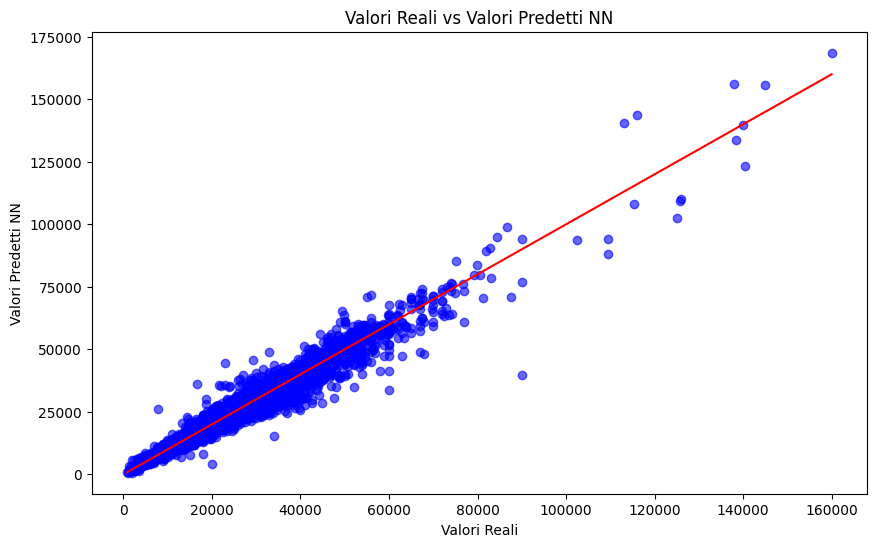

In [18]:
predicted_prices_nn = model.predict(X_test_scaled)
nn_mae = mean_absolute_error(y_test, predicted_prices_nn)
nn_r2 = r2_score(y_test, predicted_prices_nn)

print('Neural Network test MAE = ', nn_mae)
print('Neural Network test R^2 = ', nn_r2)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, predicted_prices_nn, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel('Valori Reali')
plt.ylabel('Valori Predetti NN')
plt.title('Valori Reali vs Valori Predetti NN')
plt.show()


## XGB Regressor

Come quarto modello è stato scelto XGB (Extreme Gradient Boosting). E' noto per essere ottimizzato in termini di velocità ed accuratezza, ed, a differenza del semplice Gradient Boosting, utilizza una regolarizzazione L1 e L2 integrata, che riduce il rischio di overfitting, soprattutto quando si ha un dataset con molte feature.

In [11]:
param_dist = {
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 400, 600, 800, 1000, 1200, 1400, 1600, 1800],
    'max_depth': [3, 6, 9, 12, 15, 18], #def 6
    'min_child_weight': [1, 2, 4, 6, 8, 10], #def 1
    'max_leaves': [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60], #relevant if loossguide is choosen
    'grow_policy': ['depthwise', 'lossguide'],
}

xgb = XGBRegressor()

rand_search = RandomizedSearchCV(estimator=xgb,
                                 param_distributions=param_dist,
                                 n_iter=50,
                                 scoring='neg_mean_absolute_error',
                                 cv=5,
                                 random_state=42) #for community value

rand_search.fit(X_train_scaled, y_train)

print("Best hyperparameters:", rand_search.best_params_)

Best hyperparameters: {'n_estimators': 1400, 'min_child_weight': 1, 'max_leaves': 55, 'max_depth': 18, 'learning_rate': 0.1, 'grow_policy': 'depthwise'}


In [19]:
XGBModel = XGBRegressor(n_estimators=1400, min_child_weight=1, max_leaves=55, max_depth=18, learning_rate=0.1, grow_policy='depthwise')

XGBModel.fit(X_train_scaled,y_train,verbose=True)

predicted_prices_XGB = XGBModel.predict(X_test_scaled)
xgb_mae = mean_absolute_error(y_test, predicted_prices_XGB)
xgb_r2 = r2_score(y_test, predicted_prices_XGB)

print('XGB Regressor test MAE = ', xgb_mae)
print('XGB Regressor test R^2 = ', xgb_r2)



XGB Regressor test MAE =  1340.7710797297038
XGB Regressor test R^2 =  0.9681712058092455


# Fase 3: Conclusioni

Dopo aver addestrato e valutato i quattro modelli, andiamo a confrontare i risultati ottenuti, in particolare MAE ed R2.

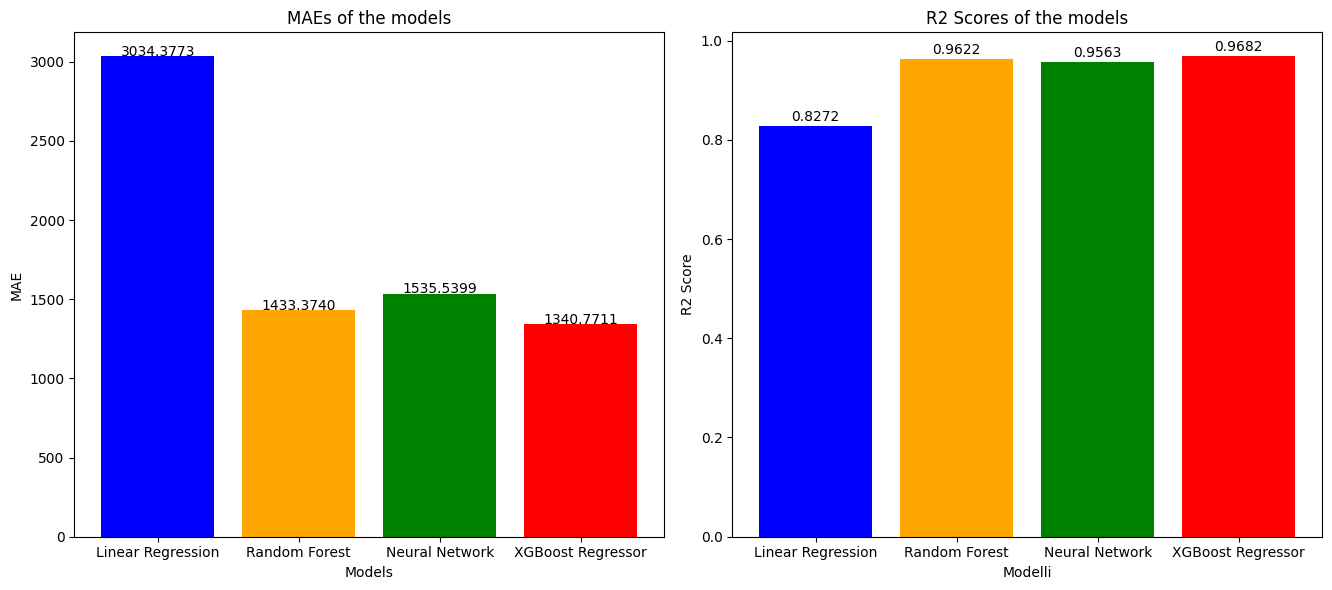

In [27]:
model_names = ['Linear Regression', 'Random Forest', 'Neural Network', 'XGBoost Regressor']
mae_values = [lr_mae, rf_mae, nn_mae, xgb_mae]
r2_values = [lr_r2, rf_r2, nn_r2, xgb_r2]

#MAE
plt.figure(figsize=(20, 6))
plt.subplot(131)
bars = plt.bar(model_names, mae_values, color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Models')
plt.ylabel('MAE')
plt.title('MAEs of the models')

for bar, value in zip(bars, mae_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{value:.4f}', ha='center', color='black')

#R2
plt.subplot(132)
bars = plt.bar(model_names, r2_values, color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Modelli')
plt.ylabel('R2 Score')
plt.title('R2 Scores of the models')

for bar, value in zip(bars, r2_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{value:.4f}', ha='center', color='black')

plt.tight_layout()
plt.show()